In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import joblib
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from sample_data.tst_model import TST

In [2]:
# Load dataset
df = pd.read_csv('/content/sample_data/USDCHFM5.csv', encoding='utf-16', sep=r'\s*,\s*', engine='python', quotechar='"')
df.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Extra']
df['Date'] = pd.to_datetime(df['Date'].str.replace(r'^"|"$', '', regex=True).str.strip(), format='%Y.%m.%d %H:%M', errors='coerce')

In [3]:

# Konversi kolom DateTime ke tipe datetime, lalu jadikan index
df.set_index('Date', inplace=True)

# Print bossku
print(df.head())
print(df.dtypes)

                        Open     High      Low    Close  Volume  Extra
Date                                                                  
2022-07-12 09:20:00  0.98408  0.98427  0.98359  0.98390     462      0
2022-07-12 09:25:00  0.98389  0.98422  0.98355  0.98412     454      0
2022-07-12 09:30:00  0.98413  0.98451  0.98363  0.98390     581      0
2022-07-12 09:35:00  0.98390  0.98428  0.98370  0.98423     540      0
2022-07-12 09:40:00  0.98423  0.98442  0.98406  0.98417     477      0
Open      float64
High      float64
Low       float64
Close     float64
Volume      int64
Extra       int64
dtype: object


In [4]:
# Jika ingin hanya mengambil kolom OHLC, bisa tambahkan volume dkk
ohlc = df[['Open','High','Low','Close']]
print(ohlc.head())

                        Open     High      Low    Close
Date                                                   
2022-07-12 09:20:00  0.98408  0.98427  0.98359  0.98390
2022-07-12 09:25:00  0.98389  0.98422  0.98355  0.98412
2022-07-12 09:30:00  0.98413  0.98451  0.98363  0.98390
2022-07-12 09:35:00  0.98390  0.98428  0.98370  0.98423
2022-07-12 09:40:00  0.98423  0.98442  0.98406  0.98417


In [4]:
scaler = StandardScaler(feature_range=(0, 1))
ohlc_scaled = scaler.fit_transform(ohlc)
print("Contoh hasil normalisasi:", ohlc_scaled[:3])

In [5]:
def create_multistep_dataset(data, window_size=24, steps_ahead=5):
    X, y = [], []
    for i in range(len(data) - window_size - steps_ahead):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size:i + window_size + steps_ahead])
    return np.array(X), np.array(y)

In [6]:
window_size = 24     # 1 jam (jika data pakai dataset usdchfm5)
steps_ahead = 5      # prediksi 5 bar ke depan 5x5menit = 25 menit

In [7]:
X, y = create_multistep_dataset(ohlc, window_size, steps_ahead)
print("X shape:", X.shape)  # (samples, 12, 4) 12 timestep dengan 4 fitur dataset OHLC gacor
print("y shape:", y.shape)  # (samples, 5, 4) 5 timestep prediksi ahead dengan4 fitur dataset OHLC gacor

X shape: (99985, 24, 4)
y shape: (99985, 5, 4)


In [8]:
# Split train-test tanpa shuffle (biar tetap urutan waktu)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [9]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape :", X_test.shape)
print("y_test shape :", y_test.shape)

X_train shape: (79988, 24, 4)
y_train shape: (79988, 5, 4)
X_test shape : (19997, 24, 4)
y_test shape : (19997, 5, 4)


In [10]:


class OHLCMultiStepDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = OHLCMultiStepDataset(X_train, y_train)
test_dataset = OHLCMultiStepDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [11]:
# Ambil satu batch dari train_loader
for X_batch, y_batch in train_loader:
    print("X_batch shape:", X_batch.shape)
    print("y_batch shape:", y_batch.shape)
    print("Contoh X_batch[0]:\n", X_batch[0])
    print("Contoh y_batch[0]:\n", y_batch[0])
    break  # supaya hanya print 1 batch


X_batch shape: torch.Size([64, 24, 4])
y_batch shape: torch.Size([64, 5, 4])
Contoh X_batch[0]:
 tensor([[0.8876, 0.8876, 0.8875, 0.8875],
        [0.8875, 0.8875, 0.8873, 0.8874],
        [0.8874, 0.8875, 0.8872, 0.8873],
        [0.8873, 0.8874, 0.8872, 0.8874],
        [0.8874, 0.8875, 0.8871, 0.8873],
        [0.8873, 0.8874, 0.8872, 0.8872],
        [0.8872, 0.8874, 0.8869, 0.8872],
        [0.8872, 0.8877, 0.8872, 0.8877],
        [0.8877, 0.8878, 0.8873, 0.8873],
        [0.8873, 0.8874, 0.8871, 0.8873],
        [0.8873, 0.8877, 0.8872, 0.8875],
        [0.8875, 0.8879, 0.8875, 0.8878],
        [0.8878, 0.8879, 0.8877, 0.8878],
        [0.8878, 0.8882, 0.8878, 0.8881],
        [0.8881, 0.8882, 0.8879, 0.8880],
        [0.8880, 0.8881, 0.8877, 0.8881],
        [0.8881, 0.8892, 0.8880, 0.8892],
        [0.8892, 0.8893, 0.8887, 0.8888],
        [0.8888, 0.8888, 0.8882, 0.8887],
        [0.8887, 0.8887, 0.8882, 0.8885],
        [0.8885, 0.8888, 0.8881, 0.8882],
        [0.8882, 0.88

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = TST(c_in=4, c_out=5*4, seq_len=24).to(device)  # pastikan output 20
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
print(model)

# TST(
#     c_in=4,
#     c_out=5*4,
#     seq_len=12,
#     d_model=128,           # Dimensi embedding / representasi
#     n_heads=8,             # Jumlah attention head
#     d_k=16, d_v=16,        # Dimensi masing-masing head (opsional)
#     n_layers=3,            # Jumlah encoder layer
#     d_ff=256,              # Ukuran hidden layer pada feedforward
#     dropout=0.1,           # Dropout seluruh network
#     fc_dropout=0.0,        # Dropout pada final dense layer
#     act="gelu",            # Fungsi aktivasi (bisa diganti 'relu')
#     y_range=None,          # Bisa pakai range sigmoid output (contoh: (0,1))
# )


TST(
  (W_P): Linear(in_features=4, out_features=128, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (encoder): _TSTEncoder(
    (layers): ModuleList(
      (0-2): 3 x _TSTEncoderLayer(
        (self_attn): _MultiHeadAttention(
          (W_Q): Linear(in_features=128, out_features=128, bias=False)
          (W_K): Linear(in_features=128, out_features=128, bias=False)
          (W_V): Linear(in_features=128, out_features=128, bias=False)
          (W_O): Linear(in_features=128, out_features=128, bias=False)
          (attention): _ScaledDotProductAttention()
        )
        (dropout_attn): Dropout(p=0.1, inplace=False)
        (batchnorm_attn): Sequential(
          (0): Transpose()
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): Transpose()
        )
        (ff): Sequential(
          (0): Linear(in_features=128, out_features=256, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.1, i

In [13]:
# Model
model = TST(c_in=4, c_out=5*4, seq_len=24).to(device)


In [14]:
# Loss dan optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)


In [15]:
# Config manual
epochs = 20
verbose = True

# Tracking loss
train_losses = []
val_losses = []

for epoch in range(1, epochs + 1):
    model.train()
    total_loss = 0

    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device).permute(0, 2, 1)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        output = model(X_batch).view(-1, 5, 4)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation step
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device).permute(0, 2, 1)
            y_batch = y_batch.to(device)

            output = model(X_batch).view(-1, 5, 4)
            val_loss = criterion(output, y_batch)
            total_val_loss += val_loss.item()

    avg_val_loss = total_val_loss / len(test_loader)
    val_losses.append(avg_val_loss)

    if verbose:
        print(f"Epoch {epoch:02d}/{epochs} - Train Loss: {avg_train_loss:.6f} - Val Loss: {avg_val_loss:.6f}")


Epoch 01/20 - Train Loss: 0.007848 - Val Loss: 0.349910
Epoch 02/20 - Train Loss: 0.000614 - Val Loss: 0.390501
Epoch 03/20 - Train Loss: 0.000625 - Val Loss: 0.483622
Epoch 04/20 - Train Loss: 0.000677 - Val Loss: 0.598046
Epoch 05/20 - Train Loss: 0.000539 - Val Loss: 0.806982
Epoch 06/20 - Train Loss: 0.000472 - Val Loss: 1.011783
Epoch 07/20 - Train Loss: 0.000585 - Val Loss: 1.084787
Epoch 08/20 - Train Loss: 0.000456 - Val Loss: 1.554885
Epoch 09/20 - Train Loss: 0.000465 - Val Loss: 1.194848
Epoch 10/20 - Train Loss: 0.000420 - Val Loss: 1.355812
Epoch 11/20 - Train Loss: 0.000435 - Val Loss: 1.290585
Epoch 12/20 - Train Loss: 0.000412 - Val Loss: 1.178602
Epoch 13/20 - Train Loss: 0.000380 - Val Loss: 0.886501
Epoch 14/20 - Train Loss: 0.000439 - Val Loss: 0.792786
Epoch 15/20 - Train Loss: 0.000336 - Val Loss: 0.595671
Epoch 16/20 - Train Loss: 0.000936 - Val Loss: 0.153752
Epoch 17/20 - Train Loss: 0.000317 - Val Loss: 0.106294
Epoch 18/20 - Train Loss: 0.000275 - Val Loss: 0

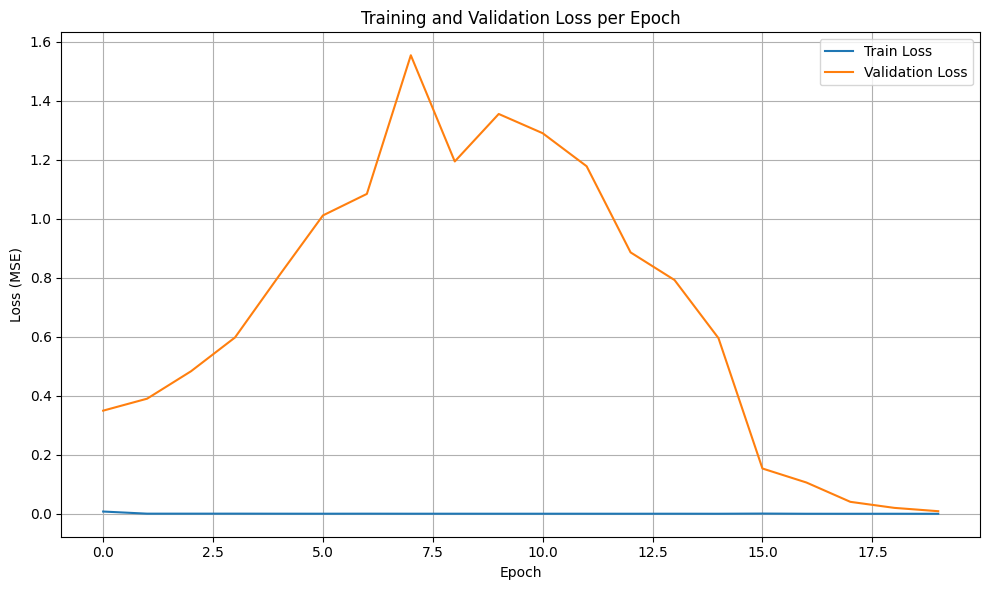

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [17]:
#Mclarenlu warna apa bos?
torch.save(model.state_dict(), "tst_USDCHF5_24Timestep.pt")
print("Model saved to 'tst_ohlc_model.pt'")


Model saved to 'tst_ohlc_model.pt'


In [18]:
# Ambil satu sample dari test set
sample_input = X_test[0]  # shape: (12, 4)
sample_input = torch.tensor(sample_input, dtype=torch.float32).unsqueeze(0)  # (1, 12, 4)
sample_input = sample_input.permute(0, 2, 1).to(device)  # jadi (1, 4, 12)

# Load model dan jalankan prediksi
model.eval()
with torch.no_grad():
    output = model(sample_input).view(-1, 5, 4).cpu().numpy()  # (1, 5, 4) → (5, 4)

# Tampilkan hasil prediksi
print("Hasil prediksi 5 langkah ke depan (Open, High, Low, Close):")
print(output[0])  # prediksi untuk langkah ke-1
print(output)     # semua 5 langkah

Hasil prediksi 5 langkah ke depan (Open, High, Low, Close):
[[0.7875608  0.78803027 0.7877041  0.7873445 ]
 [0.7884776  0.78778577 0.78639114 0.78711987]
 [0.78842866 0.78964096 0.78745866 0.78853023]
 [0.7882764  0.78894395 0.7873682  0.78916204]
 [0.7872323  0.7902112  0.78709817 0.7893071 ]]
[[[0.7875608  0.78803027 0.7877041  0.7873445 ]
  [0.7884776  0.78778577 0.78639114 0.78711987]
  [0.78842866 0.78964096 0.78745866 0.78853023]
  [0.7882764  0.78894395 0.7873682  0.78916204]
  [0.7872323  0.7902112  0.78709817 0.7893071 ]]]
